# Optimal Savings with IID Shocks

#### John Stachurski 

Thanks to Natasha Watkins for joint work on the code

In [1]:
!date

Sun Oct 14 17:29:39 EDT 2018




Taking $ y_0 $ as given, the agent wishes to maximize


<a id='equation-texs0_og2'></a>
<table width=100%><tr style='background-color: #FFFFFF !important;'>
<td width=10%></td>
<td width=80%>
$$
\mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right]
$$
</td><td width=10% style='text-align:center !important;'>
(2)
</td></tr></table>

subject to


<a id='equation-og_conse'></a>
<table width=100%><tr style='background-color: #FFFFFF !important;'>
<td width=10%></td>
<td width=80%>
$$
y_{t+1} = f(y_t - c_t) \xi_{t+1}
\quad \text{and} \quad
0 \leq c_t \leq y_t
\quad \text{for all } t
$$
</td><td width=10% style='text-align:center !important;'>
(3)
</td></tr></table>

where

- $ u $ is a bounded, continuous and strictly increasing utility function and  
- $ \beta \in (0, 1) $ is a discount factor  


Our aim is to iterate with the Bellman operator


<a id='equation-fcbell20_optgrowth'></a>
<table width=100%><tr style='background-color: #FFFFFF !important;'>
<td width=10%></td>
<td width=80%>
$$
Tv(y) := \max_{0 \leq c \leq y}
\left\{
    u(c) + \beta \int v(f(y - c) z) \phi(dz)
\right\}
\qquad (y \in \mathbb R_+)
$$
</td><td width=10% style='text-align:center !important;'>
(11)
</td></tr></table>


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from interpolation import interp
from numba import njit, prange
from quantecon.optimize.scalar_maximization import brent_max



We will hold the primitives of the optimal growth model in a class

The distribution $ \phi $ of the shock is assumed to be lognormal,
and so a draw from $ \exp(\mu + \sigma \zeta) $ when $ \zeta $ is standard normal

In [3]:
class OptimalGrowthModel:

    def __init__(self,
                 f,
                 u,
                 β=0.96,
                 μ=0,
                 s=0.1,
                 grid_max=4,
                 grid_size=200,
                 shock_size=250):

        self.β, self.μ, self.s = β, μ, s
        self.f, self.u = f, u

        self.y_grid = np.linspace(1e-5, grid_max, grid_size)       # Set up grid
        self.shocks = np.exp(μ + s * np.random.randn(shock_size))  # Store shocks

### The Bellman Operator

Here’s a function that generates a Bellman operator using linear interpolation

In [4]:
def operator_factory(og, parallel_flag=True):
    """
    A function factory for building the Bellman operator, as well as
    a function that computes greedy policies.

    Here og is an instance of OptimalGrowthModel.
    """

    f, u, β = og.f, og.u, og.β
    y_grid, shocks = og.y_grid, og.shocks

    @njit
    def objective(c, v, y):
        """
        The right hand side of the Bellman equation
        """
        # First turn v into a function via interpolation
        v_func = lambda x: interp(y_grid, v, x)
        return u(c) + β * np.mean(v_func(f(y - c) * shocks))

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator
        """
        v_new = np.empty_like(v)
        for i in prange(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal v at y
            v_max = brent_max(objective, 1e-10, y, args=(v, y))[1]
            v_new[i] = v_max
        return v_new

    @njit
    def get_greedy(v):
        """
        Computes the v-greedy policy of a given function v
        """
        σ = np.empty_like(v)
        for i in range(len(y_grid)):
            y = y_grid[i]
            # Solve for optimal c at y
            c_max = brent_max(objective, 1e-10, y, args=(v, y))[0]
            σ[i] = c_max
        return σ

    return T, get_greedy

The function operator_factory takes a class that represents the growth model,
and returns the operator T and a function get_greedy that we will use to solve the model

Notice that the expectation in [(11)](#equation-fcbell20_optgrowth) is computed via Monte Carlo, using the approximation

$$
\int v(f(y - c) z) \phi(dz) \approx \frac{1}{n} \sum_{i=1}^n v(f(y - c) \xi_i)
$$

where $ \{\xi_i\}_{i=1}^n $ are IID draws from $ \phi $

Monte Carlo is not always the most efficient way to compute integrals numerically
but it does have some theoretical advantages in the present setting

(For example, it preserves the contraction mapping property of the Bellman operator — see, e.g., [[PalS13]](zreferences.ipynb#pal2013))


<a id='benchmark-growth-mod'></a>

### An Example

Let’s test out our operator when

- $ f(k) = k^{\alpha} $  
- $ u(c) = \ln c $  
- $ \phi $ is the distribution of $ \exp(\mu + \sigma \zeta) $ when $ \zeta $ is standard normal  


As is well-known (see [[LS18]](zreferences.ipynb#ljungqvist2012), section 3.1.2), for this particular problem an exact analytical solution is available, with


<a id='equation-dpi_tv'></a>
<table width=100%><tr style='background-color: #FFFFFF !important;'>
<td width=10%></td>
<td width=80%>
$$
v^*(y) =
\frac{\ln (1 - \alpha \beta) }{ 1 - \beta}
+
\frac{(\mu + \alpha \ln (\alpha \beta))}{1 - \alpha}
 \left[
     \frac{1}{1- \beta} - \frac{1}{1 - \alpha \beta}
 \right]
 +
 \frac{1}{1 - \alpha \beta} \ln y
$$
</td><td width=10% style='text-align:center !important;'>
(12)
</td></tr></table>

The optimal consumption policy is

$$
\sigma^*(y) = (1 - \alpha \beta ) y
$$

We will define functions to compute the closed form solutions to check our answers

In [5]:
def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

### A First Test

To test our code, we want to see if we can replicate the analytical solution
numerically, using fitted value function iteration

First, having run the code for the general model shown above, let’s
generate an instance of the model and generate its Bellman operator

We first need to define a jitted version of the production function

In [6]:
α = 0.4  # Production function parameter

@njit
def f(k):
    """
    Cobb-Douglas production function
    """
    return k**α

Now we will create an instance of the model and assign it to the variable og

This instance will use the Cobb-Douglas production function and log utility

In [7]:
og = OptimalGrowthModel(f=f, u=np.log)

We will use og to generate the Bellman operator and a function that computes
greedy policies

In [8]:
T, get_greedy = operator_factory(og)

Now let’s do some tests

As one preliminary test, let’s see what happens when we apply our Bellman operator to the exact solution $ v^* $

In theory, the resulting function should again be $ v^* $

In practice we expect some small numerical error

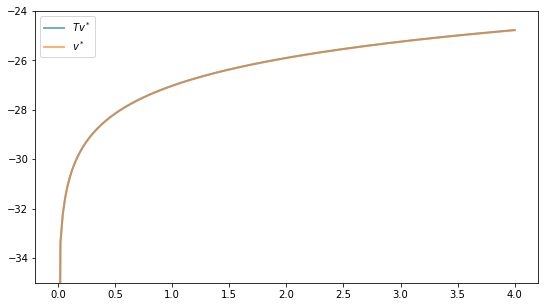

In [9]:
y_grid = og.y_grid
β, μ = og.β, og.μ

v_init = v_star(y_grid, α, β, μ)  # Start at the solution
v = T(v_init)                     # Apply the Bellman operator once

fig, ax = plt.subplots(figsize=(9, 5))
ax.set_ylim(-35, -24)
ax.plot(y_grid, v, lw=2, alpha=0.6, label='$Tv^*$')
ax.plot(y_grid, v_init, lw=2, alpha=0.6, label='$v^*$')
ax.legend()
plt.show()

The two functions are essentially indistinguishable, so we are off to a good start

Now let’s have a look at iterating with the Bellman operator, starting off
from an arbitrary initial condition

The initial condition we’ll start with is $ v(y) = 5 \ln (y) $

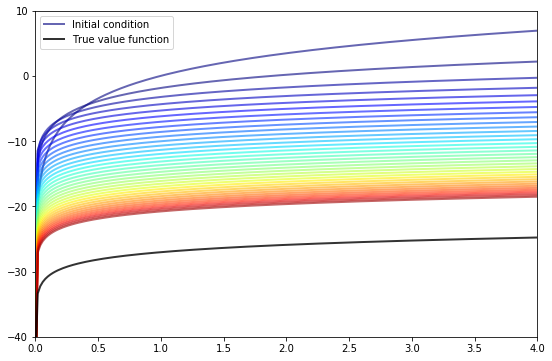

In [10]:
v = 5 * np.log(y_grid)  # An initial condition
n = 35

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(y_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial condition')

for i in range(n):
    v = T(v)  # Apply the Bellman operator
    ax.plot(y_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.plot(y_grid, v_star(y_grid, α, β, μ), 'k-', lw=2,
        alpha=0.8, label='True value function')

ax.legend()
ax.set(ylim=(-40, 10), xlim=(np.min(y_grid), np.max(y_grid)))
plt.show()

The figure shows

1. the first 36 functions generated by the fitted value function iteration algorithm, with hotter colors given to higher iterates  
1. the true value function $ v^* $ drawn in black  


The sequence of iterates converges towards $ v^* $

We are clearly getting closer

We can write a function that iterates until the difference is below a particular
tolerance level

In [30]:
def solve_model(og,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    T, _ = operator_factory(og, parallel_flag=use_parallel)

    # Set up loop
    v = np.log(og.y_grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

We can check our result by plotting it against the true value

Error at iteration 25 is 0.4039123560122704.
Error at iteration 50 is 0.14556531673825646.
Error at iteration 75 is 0.0524612622392695.
Error at iteration 100 is 0.018906866673322753.
Error at iteration 125 is 0.006813972675239199.
Error at iteration 150 is 0.002455733381001579.
Error at iteration 175 is 0.0008850382480112273.
Error at iteration 200 is 0.00031896487892524306.
Error at iteration 225 is 0.00011495389518145771.

Converged in 229 iterations.


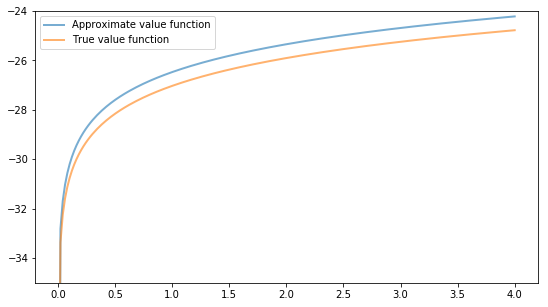

In [16]:
v_solution = solve_model(og)

fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(y_grid, v_solution, lw=2, alpha=0.6,
        label='Approximate value function')

ax.plot(y_grid, v_star(y_grid, α, β, μ), lw=2,
        alpha=0.6, label='True value function')

ax.legend()
ax.set_ylim(-35, -24)
plt.show()

The figure shows that we are pretty much on the money

### The Policy Function


<a id='index-8'></a>
To compute an approximate optimal policy, we will use the second function
returned from operator_factory that backs out the optimal policy
from the solution to the Bellman equation

The next figure compares the result to the exact solution, which, as mentioned
above, is $ \sigma(y) = (1 - \alpha \beta) y $

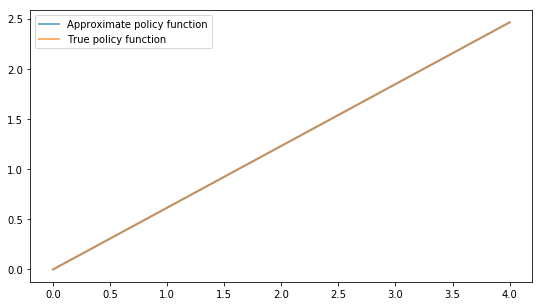

In [17]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(y_grid, get_greedy(v_solution), lw=2,
        alpha=0.6, label='Approximate policy function')

ax.plot(y_grid, σ_star(y_grid, α, β),
        lw=2, alpha=0.6, label='True policy function')

ax.legend()
plt.show()

The figure shows that we’ve done a good job in this instance of approximating
the true policy

### Exercise 1

Here’s one solution (assuming as usual that you’ve executed everything above)

In [18]:
def simulate_og(σ_func, og, α, y0=0.1, ts_length=100):
    '''
    Compute a time series given consumption policy σ.
    '''
    y = np.empty(ts_length)
    ξ = np.random.randn(ts_length-1)
    y[0] = y0
    for t in range(ts_length-1):
        y[t+1] = (y[t] - σ_func(y[t]))**α * np.exp(og.μ + og.s * ξ[t])
    return y

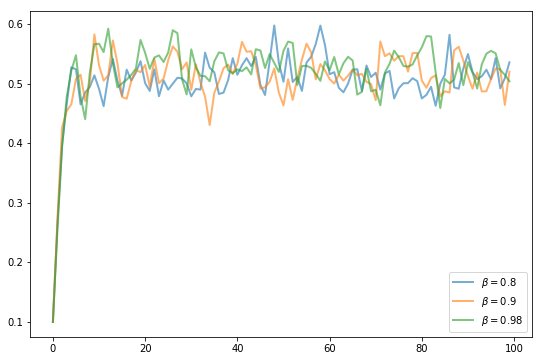

In [19]:
fig, ax = plt.subplots(figsize=(9, 6))

for β in (0.8, 0.9, 0.98):

    og = OptimalGrowthModel(f, np.log, β=β, s=0.05)
    y_grid = og.y_grid

    v_solution = solve_model(og, verbose=False)

    σ_star = get_greedy(v_solution)
    σ_func = lambda x: interp(y_grid, σ_star, x)  # Define an optimal policy function
    y = simulate_og(σ_func, og, α)
    ax.plot(y, lw=2, alpha=0.6, label=rf'$\beta = {β}$')

ax.legend(loc='lower right')
plt.show()